# Analyzing Fair PCA on different datasets


## Exploratory Data Analysis


### Imports


In [86]:
from sklearn.model_selection import train_test_split
import dython
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier


In [87]:
df_recidivism = pd.read_csv(f'data/propublica_data_for_fairml.csv')

df_recidivism['Caucasian'] = ((df_recidivism['Other'] == 0) & (df_recidivism['African_American'] == 0) & (
    df_recidivism['Asian'] == 0) & (df_recidivism['Hispanic'] == 0) & (df_recidivism['Native_American'] == 0)).astype(int)
df_recidivism['Between_TwentyFive_And_FourtyFive'] = (
    (df_recidivism['Age_Above_FourtyFive'] == 0) & (df_recidivism['Age_Below_TwentyFive'] == 0)).astype(int)
df_recidivism['Male'] = (df_recidivism['Female'] == 0).astype(int)

# revert one hot encoding
races = ['Other', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Caucasian']
df_recidivism['Race'] = df_recidivism[races].idxmax(axis=1)
df_recidivism = df_recidivism.drop(races, axis=1)

genders = ['Female', 'Male']
df_recidivism['Gender'] = df_recidivism[genders].idxmax(axis=1)
df_recidivism = df_recidivism.drop(genders, axis=1)

age_group = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Between_TwentyFive_And_FourtyFive']
df_recidivism['Age_Group'] = df_recidivism[age_group].idxmax(axis=1)
df_recidivism = df_recidivism.drop(age_group, axis=1)

df_recidivism = df_recidivism.drop('score_factor', axis=1)
df_recidivism = df_recidivism[df_recidivism["Race"].isin(["African_American", "Caucasian"])]
df_recidivism = df_recidivism.reset_index(drop=True)


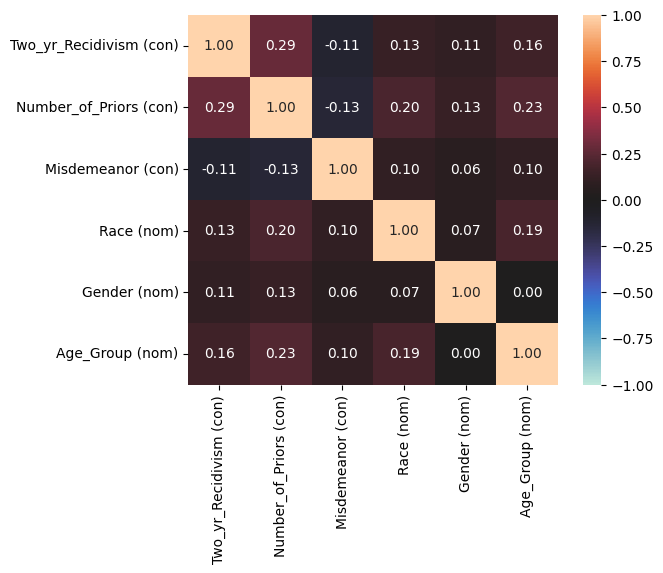

{'corr':                          Two_yr_Recidivism (con)  Number_of_Priors (con)  \
 Two_yr_Recidivism (con)                 1.000000                0.286675   
 Number_of_Priors (con)                  0.286675                1.000000   
 Misdemeanor (con)                      -0.111290               -0.133964   
 Race (nom)                              0.129749                0.195713   
 Gender (nom)                            0.107261                0.127803   
 Age_Group (nom)                         0.160009                0.225212   
 
                          Misdemeanor (con)  Race (nom)  Gender (nom)  \
 Two_yr_Recidivism (con)          -0.111290    0.129749      0.107261   
 Number_of_Priors (con)           -0.133964    0.195713      0.127803   
 Misdemeanor (con)                 1.000000    0.102885      0.063162   
 Race (nom)                        0.102885    1.000000      0.067634   
 Gender (nom)                      0.063162    0.067634      1.000000   
 Age_Group (n

In [88]:
cat_cols = ["Race", "Gender", "Age_Group"]
dython.nominal.associations(df_recidivism, nominal_columns=cat_cols, mark_columns=True)

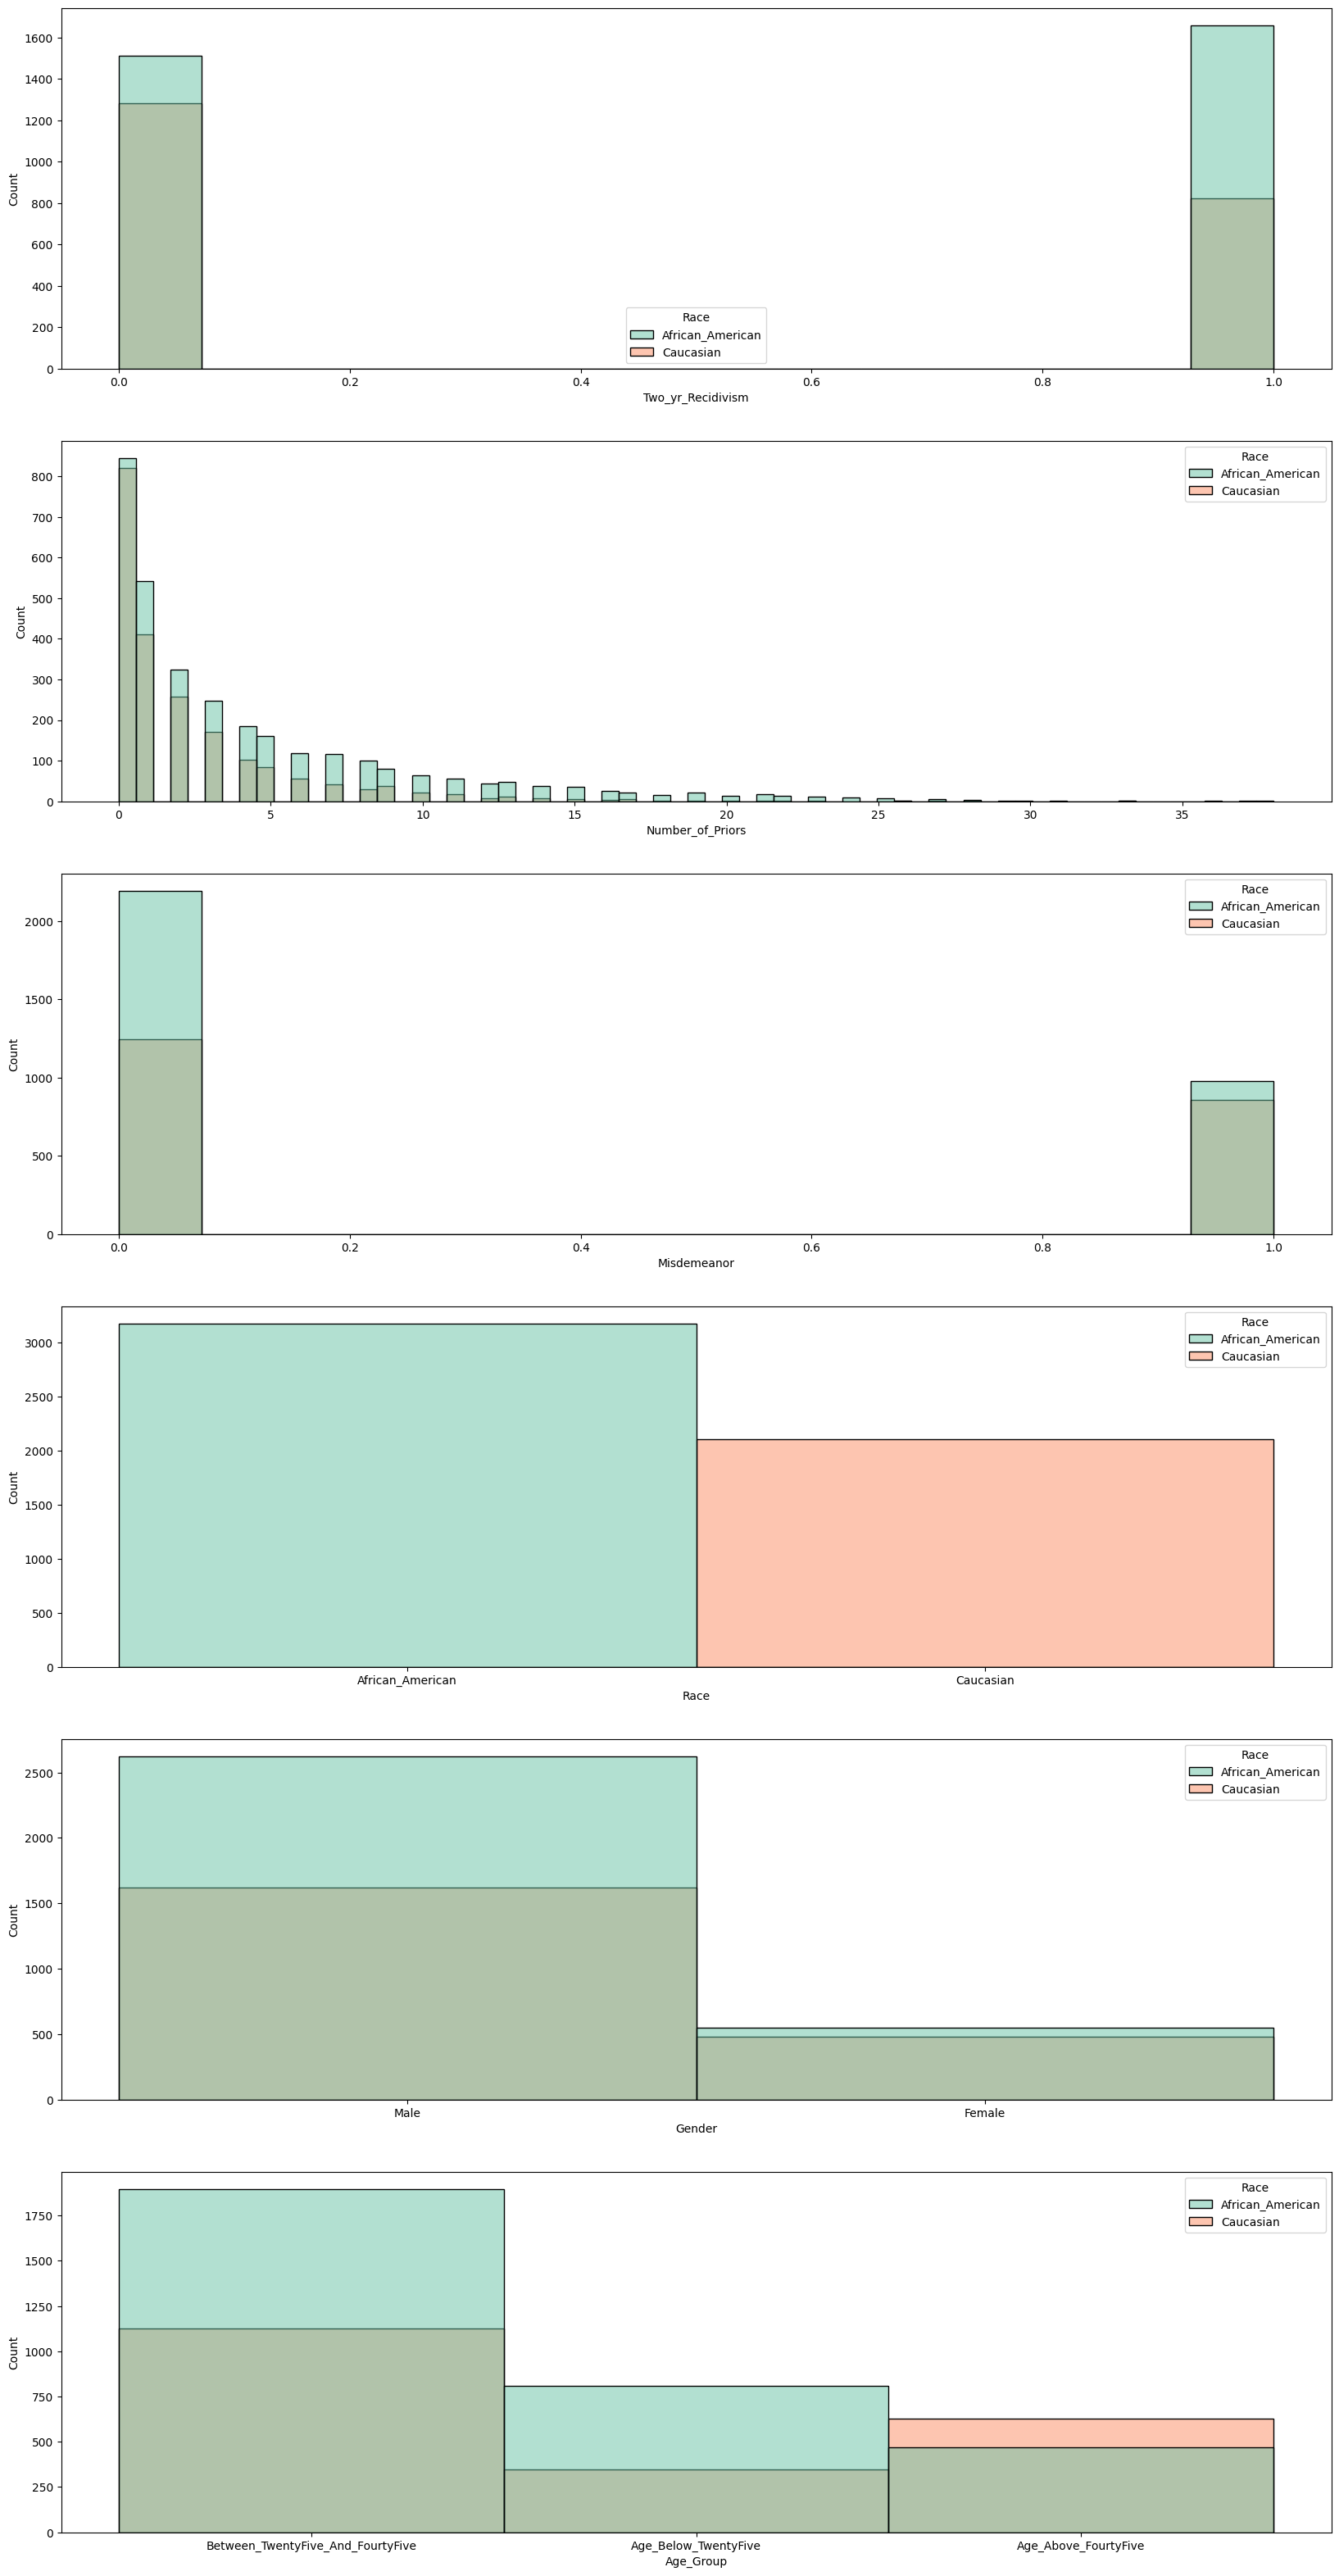

In [89]:
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(len(df_recidivism.columns), figsize=(20, 40))
for i, feature in enumerate(df_recidivism.columns):
    sns.histplot(data=df_recidivism, x=feature, hue='Race', ax=axes[i], palette='Set2')
# plt.show()


In [90]:
# one hot encode data
dummies_df_recividism = pd.get_dummies(df_recidivism, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_recividism.Two_yr_Recidivism
features = dummies_df_recividism.drop("Two_yr_Recidivism", axis=1)

features = features[["Number_of_Priors", "Misdemeanor", "Age_Group_Age_Below_TwentyFive",
                     "Age_Group_Between_TwentyFive_And_FourtyFive", "Race_Caucasian", "Gender_Male"]]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Race" in f) or ("Gender" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 4 (Race_Caucasian)
Column ID: 5 (Gender_Male)
[4, 5]


In [91]:
# last columns of our data contains the protected features
protected = X_train[:, -2:]
nonprotected = X_train[:, :-2]

protected_test = X_test[:, -2:]
nonprotected_test = X_test[:, :-2]


In [92]:
def calculate_metrics(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    recall : float
        Recall of the positive class in binary classification or weighted
        average of the recall of each class for the multiclass task.
    precision : float
        Precision of the positive class in binary classification or weighted
        average of the precision of each class for the multiclass task.
    f1_score : float
        F1 score of the positive class in binary classification or weighted
        average of the F1 score of each class for the multiclass task.
    accuracy : float
        Accuracy of the positive class in binary classification or weighted
        average of the accuracy of each class for the multiclass task.
    """

    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2

    metrics_dict = {'recall': recall,
                    'precision': precision,
                    'f1_score': f1_score,
                    'accuracy': accuracy}
    
    return metrics_dict


In [93]:
def calculate_fairness_metrics_nonencoded(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics

In [94]:
# caluclate statistical parity, equalized odds and equalized outcome for all groups
def calculate_fairness_metrics(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics


def calculate_balanced_accuracy_groups(y_true, y_pred, groups):
    """
    Calculate balanced accuracy for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['balanced_accuracy'] = calculate_metrics(
                y_true_group, y_pred_group)['accuracy']
    return metrics

### with DecisionTreeClassifier


In [95]:
# create decision tree classifier object
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(nonprotected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6664925991863282
Precision on test set: 0.6403385049365303
Recall on test set: 0.628808864265928
F1 score on test set: 0.6345213137665968


In [96]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.5458333333333333, 'equalized_odds': 0.36592818945760125, 'equalized_outcome': 0.7272727272727273}
Race_Caucasian1 : {'statistical_parity': 0.296474358974359, 'equalized_odds': 0.21354552183567727, 'equalized_outcome': 0.42857142857142855}
Gender_Male0 : {'statistical_parity': 0.2993827160493827, 'equalized_odds': 0.2775148647008858, 'equalized_outcome': 0.4715447154471545}
Gender_Male1 : {'statistical_parity': 0.4857142857142857, 'equalized_odds': 0.3343242267116905, 'equalized_outcome': 0.66110183639399}


In [97]:
# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
interval = 0.95
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        continue

    score = calculate_metrics(y_test[indices], y_pred[indices])['f1_score']
    bootstrapped_scores.append(score)

print(f"Confidence interval for the f1_score [{interval}]:" + "[{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, ((1-interval)/2)*100),
    np.percentile(bootstrapped_scores, (interval + (1-interval)/2)*100)))

Confidence interval for the f1_score [0.95]:[0.604 - 0.664]


## Fair PCA


In [98]:
df_recidivism.columns

Index(['Two_yr_Recidivism', 'Number_of_Priors', 'Misdemeanor', 'Race',
       'Gender', 'Age_Group'],
      dtype='object')

In [99]:
nonprotected

array([[11,  0,  0,  1],
       [10,  1,  0,  1],
       [ 1,  1,  0,  0],
       ...,
       [ 2,  0,  0,  1],
       [ 0,  0,  0,  1],
       [ 4,  1,  1,  0]], dtype=int64)

Text(0.5, 0, 'Principal Component')

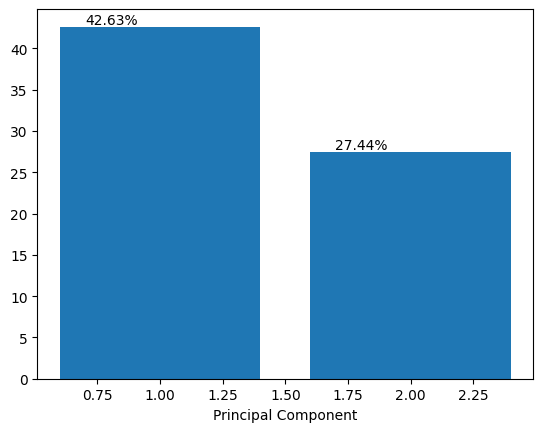

In [100]:
# apply unfair PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(nonprotected)

pca = PCA(n_components=len(features.columns)-4) # - protected features
X_pca = pca.fit_transform(non_protected_features_scaled)

# pca.explained_variance_ratio_
# scree plot bar plot
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
for i in range(len(pca.explained_variance_ratio_)):
    plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
plt.xlabel('Principal Component')

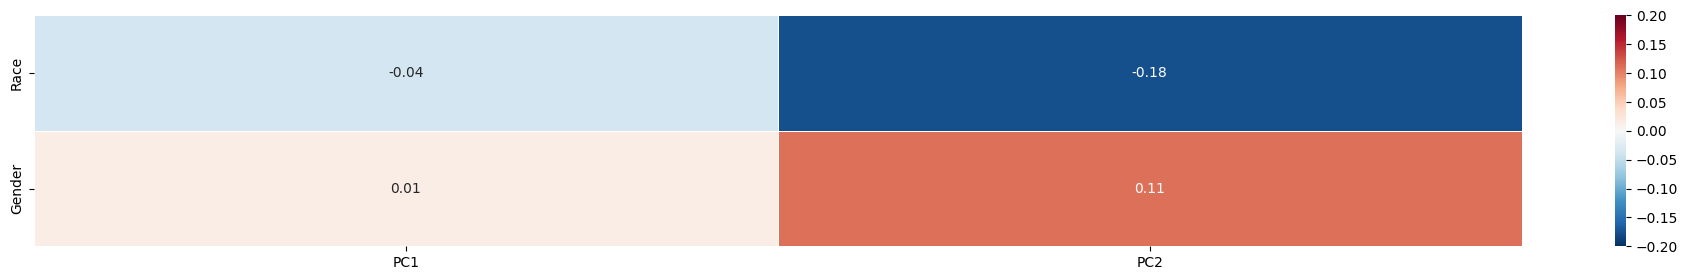

In [101]:
# corr matrix comparing protected
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))

corr = df.corr()
corr.columns=['Race', 'Gender', 'PC1', 'PC2']

rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(2)
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = ["Race", "Gender"]
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

In [102]:
# project test data with pca

# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(nonprotected_test)
X_pca_test = pca.transform(non_protected_features_scaled_test)

# project it back into the original space
X_reconstructed = pca.inverse_transform(X_pca)
X_reconstructed_test = pca.inverse_transform(X_pca_test)

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):

    # 1 is white and 0 is african american
    if protected[i][0] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])
        
    # 1 is male and 0 is female
    if protected[i][1] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))


0.41457962272667187
0.40904186759935574
0.4122268924236443
0.4144574274416099


In [103]:
# apply fair PCA
import scipy

def fair_pca(non_protected_features_scaled, n_components):
    X = non_protected_features_scaled.copy()
    # create Matrix Z with protected features
    Z = protected.copy()
    # remove mean from each column
    Z = Z - np.mean(Z, axis=0)
    # find orthonormal null space spanned by ZTX with scipy.linalg.null_space
    R = scipy.linalg.null_space(Z.T @ X)

    # Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
    eigvals, eigvecs = scipy.linalg.eig(R.T @ X.T @ X @ R)
    # sort eigenvectors by eigenvalues
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # get matrix of first n eigenvectors
    L = eigvecs[:,:n_components]

    # projection matrix U = RL
    U = R @ L

    # project data
    X_projected = X @ U

    return X_projected, Z


In [104]:
X_projected, Z = fair_pca(non_protected_features_scaled, 3)
print(X_projected)

[[-1.15674661  0.13823827]
 [-1.29816902 -1.58186027]
 [ 0.23532358 -1.11654861]
 ...
 [-0.76325987  0.97660482]
 [-0.67581837  1.1629085 ]
 [ 2.03883492 -1.61189137]]


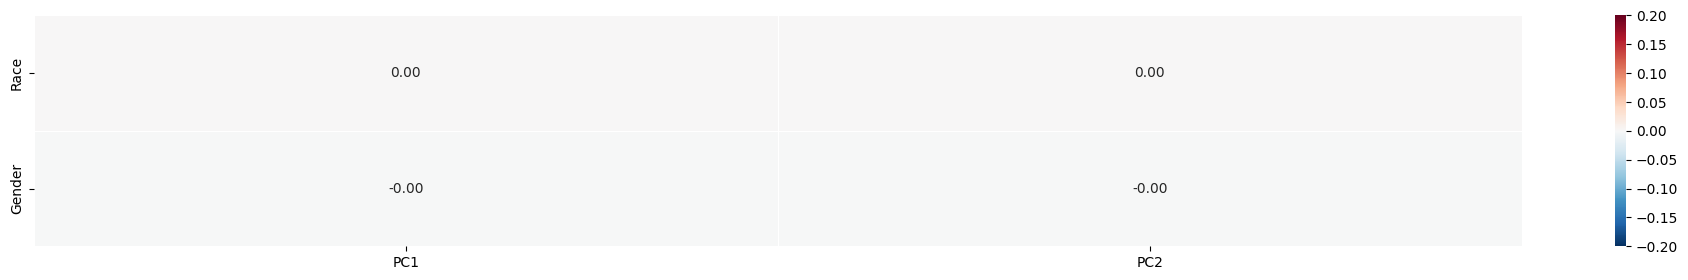

In [105]:
df = pd.DataFrame(np.concatenate((Z, X_projected), axis=1))

corr = df.corr()
corr.columns=['Race', 'Gender', 'PC1', 'PC2']

rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(2)
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = ["Race", "Gender"]
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

In [106]:
# project test data
X_test_projected = non_protected_features_scaled_test @ U

# reproject it back into the original space
X_reconstructed = X_projected @ U.T
X_reconstructed_test = X_test_projected @ U.T

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):

    # 1 is white and 0 is african american
    if protected[i][0] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])
        
    # 1 is male and 0 is female
    if protected[i][1] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))

0.43574020287276527
0.42470874673700904
0.4383123336754716
0.43027134025040603


In [107]:
# run decision tree on fair PCA data
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(X_projected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(X_test_projected)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6203829270330546
Precision on test set: 0.6329588014981273
Recall on test set: 0.46814404432132967
F1 score on test set: 0.5382165605095542


In [108]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.41875, 'equalized_odds': 0.2680394471838322, 'equalized_outcome': 0.5516528925619835}
Race_Caucasian1 : {'statistical_parity': 0.21153846153846154, 'equalized_odds': 0.14028823964819087, 'equalized_outcome': 0.29831932773109243}
Gender_Male0 : {'statistical_parity': 0.24691358024691357, 'equalized_odds': 0.16551389394490962, 'equalized_outcome': 0.34959349593495936}
Gender_Male1 : {'statistical_parity': 0.3603174603174603, 'equalized_odds': 0.251942849782416, 'equalized_outcome': 0.49248747913188645}


## Loan defaulting


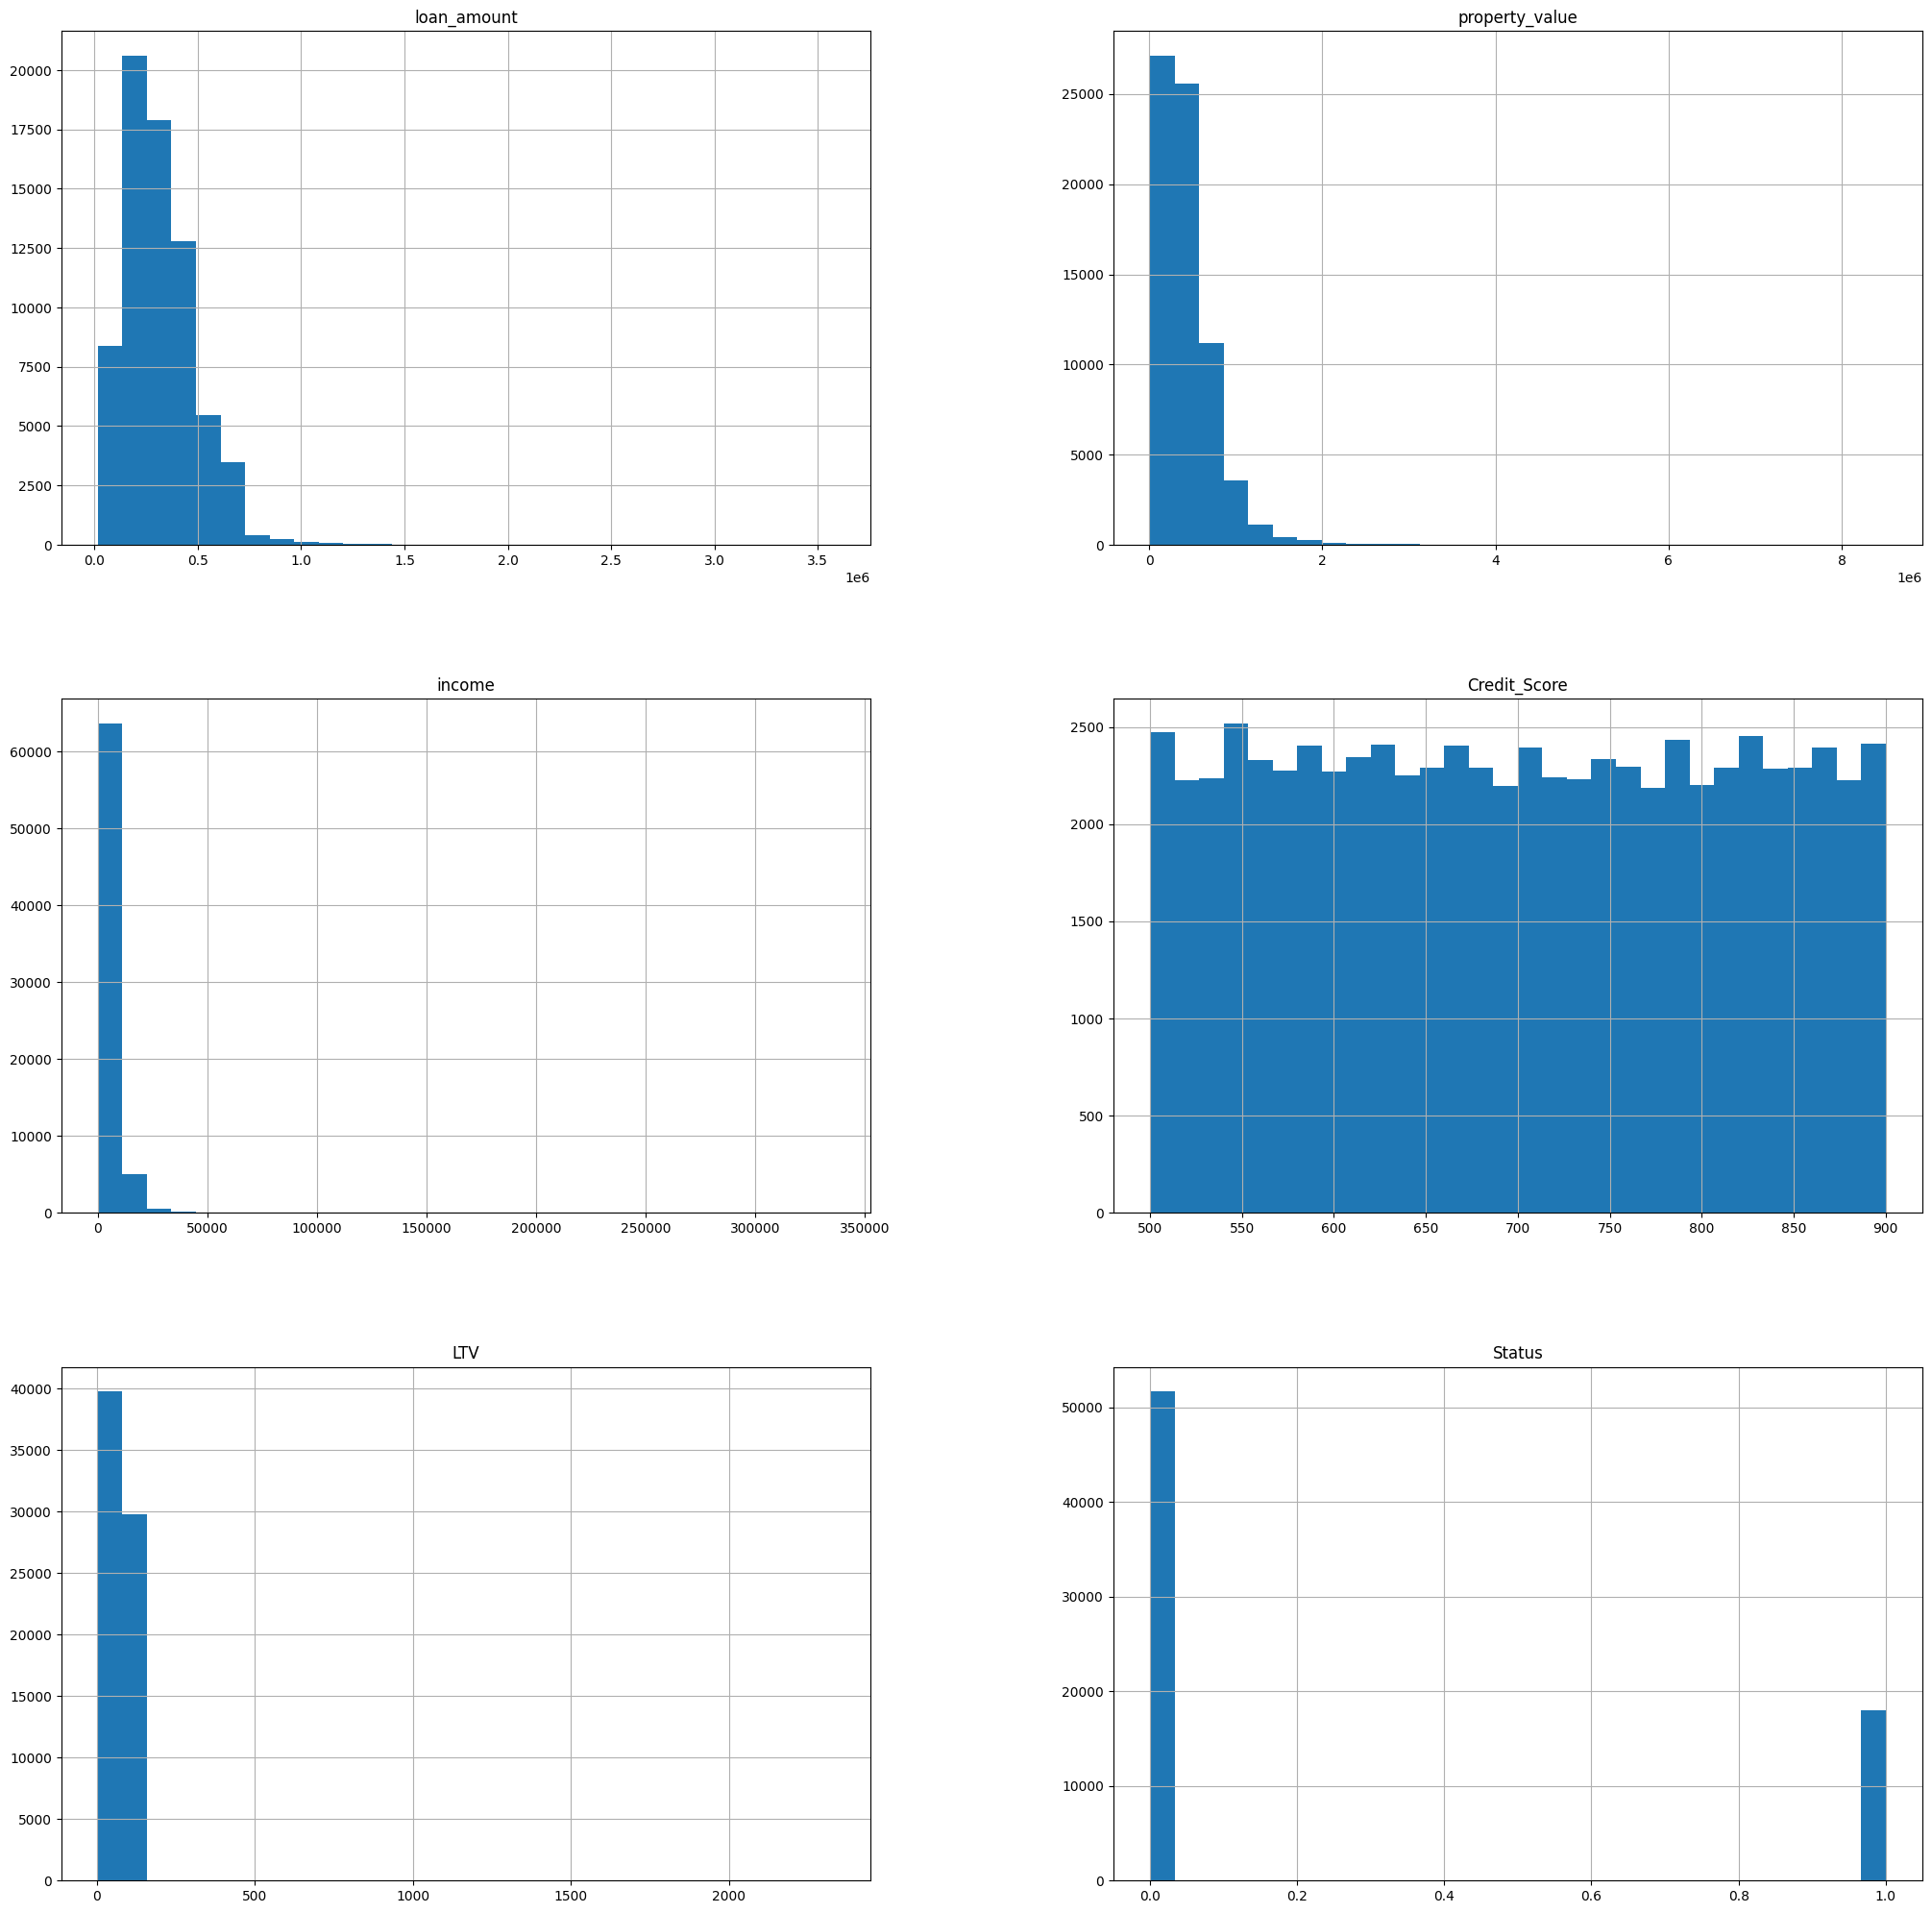

In [39]:
df_original = pd.read_csv('data/loan_default.csv')

# Dataset from https://www.kaggle.com/datasets/yasserh/loan-default-dataset?datasetId=1897041&sortBy=voteCount,
# Protected attribute is Gender
# Object is status, 0 or 1 (default or not)

# Drop all rows with nan
df_loans = df_original.drop(['Region', 'Security_Type', 'dtir1', 'total_units', 'Secured_by',
                             'term', 'open_credit', 'year', 'rate_of_interest', 'Interest_rate_spread',
                             'Upfront_charges', 'loan_limit', 'construction_type',
                             'co-applicant_credit_type', 'ID'], axis=1)

# Drop all rows from column 'Gender' that have 'Sex Not Available'
df_loans = df_loans[(df_loans['Gender'] != 'Sex Not Available')
                    & (df_loans['Gender'] != 'Joint')]

# Replace missing values with mode
df_loans['approv_in_adv'].fillna(
    df_loans['approv_in_adv'].mode()[0], inplace=True)
df_loans['loan_purpose'].fillna(
    df_loans['loan_purpose'].mode()[0], inplace=True)
df_loans['Neg_ammortization'].fillna(
    df_loans['Neg_ammortization'].mode()[0], inplace=True)
df_loans['property_value'].fillna(
    df_loans['property_value'].mode()[0], inplace=True)
df_loans['income'].fillna(df_loans['income'].mode()[0], inplace=True)
df_loans['LTV'].fillna(df_loans['LTV'].mode()[0], inplace=True)

df_loans.hist(bins=30, figsize=(25, 25))
plt.show()


In [40]:
# get list of categorical columns
num_cols = df_loans._get_numeric_data().columns
cat_cols = list(set(df_loans.columns) - set(num_cols))


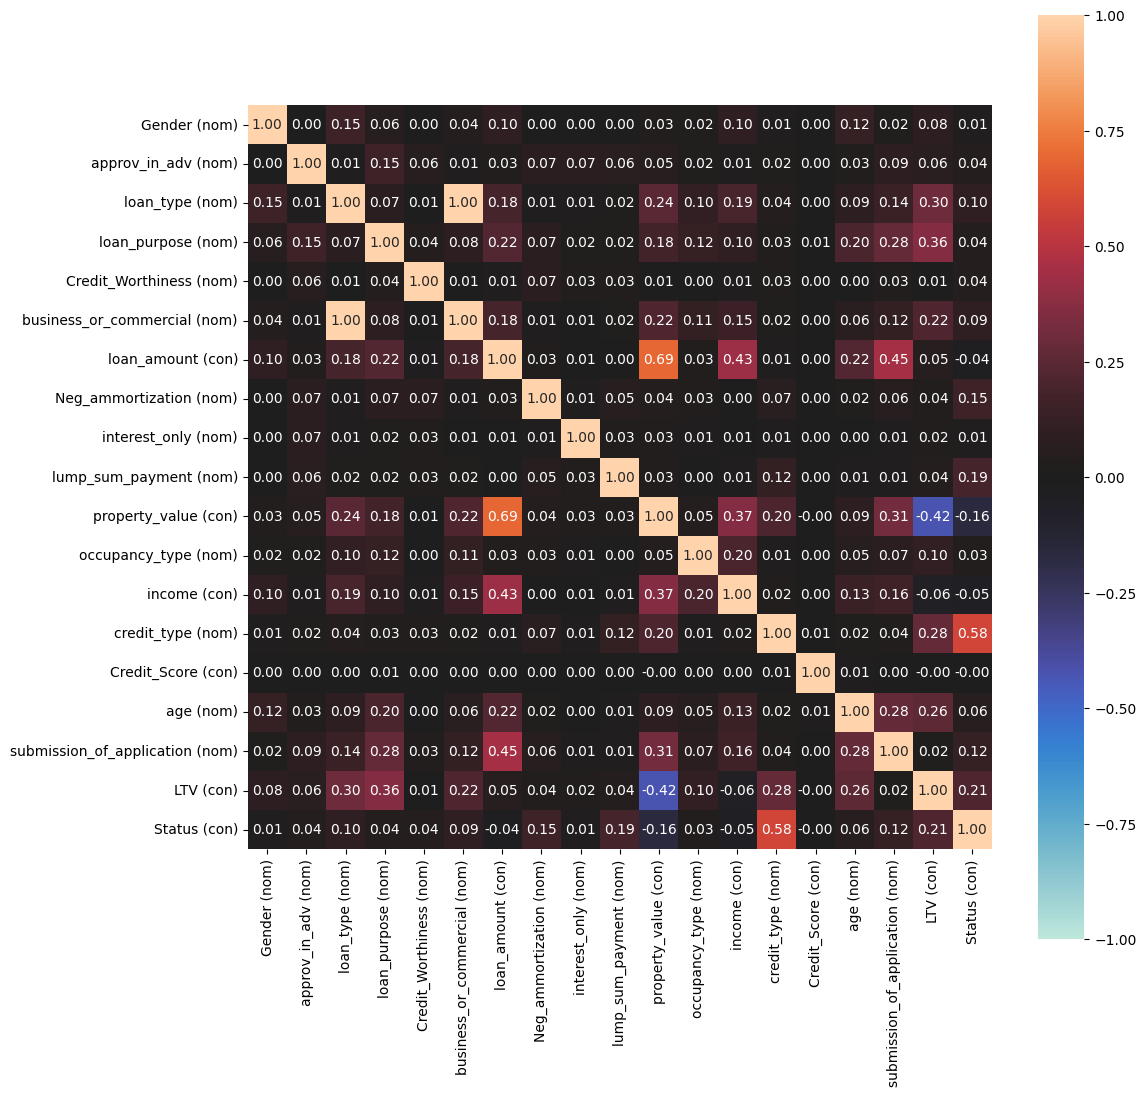

In [41]:
dython.nominal.associations(
    df_loans, nominal_columns=cat_cols, mark_columns=True, figsize=(12, 12));


In [42]:
df_loans.age.value_counts()

45-54    16627
35-44    15716
55-64    14955
25-34     9778
65-74     8701
>74       3028
<25        807
Name: age, dtype: int64

In [43]:
# combine age <54 and age >54 into one column
df_loans['age<35'] = df_loans['age'].isin(["25-34", "<25"]).astype(int)

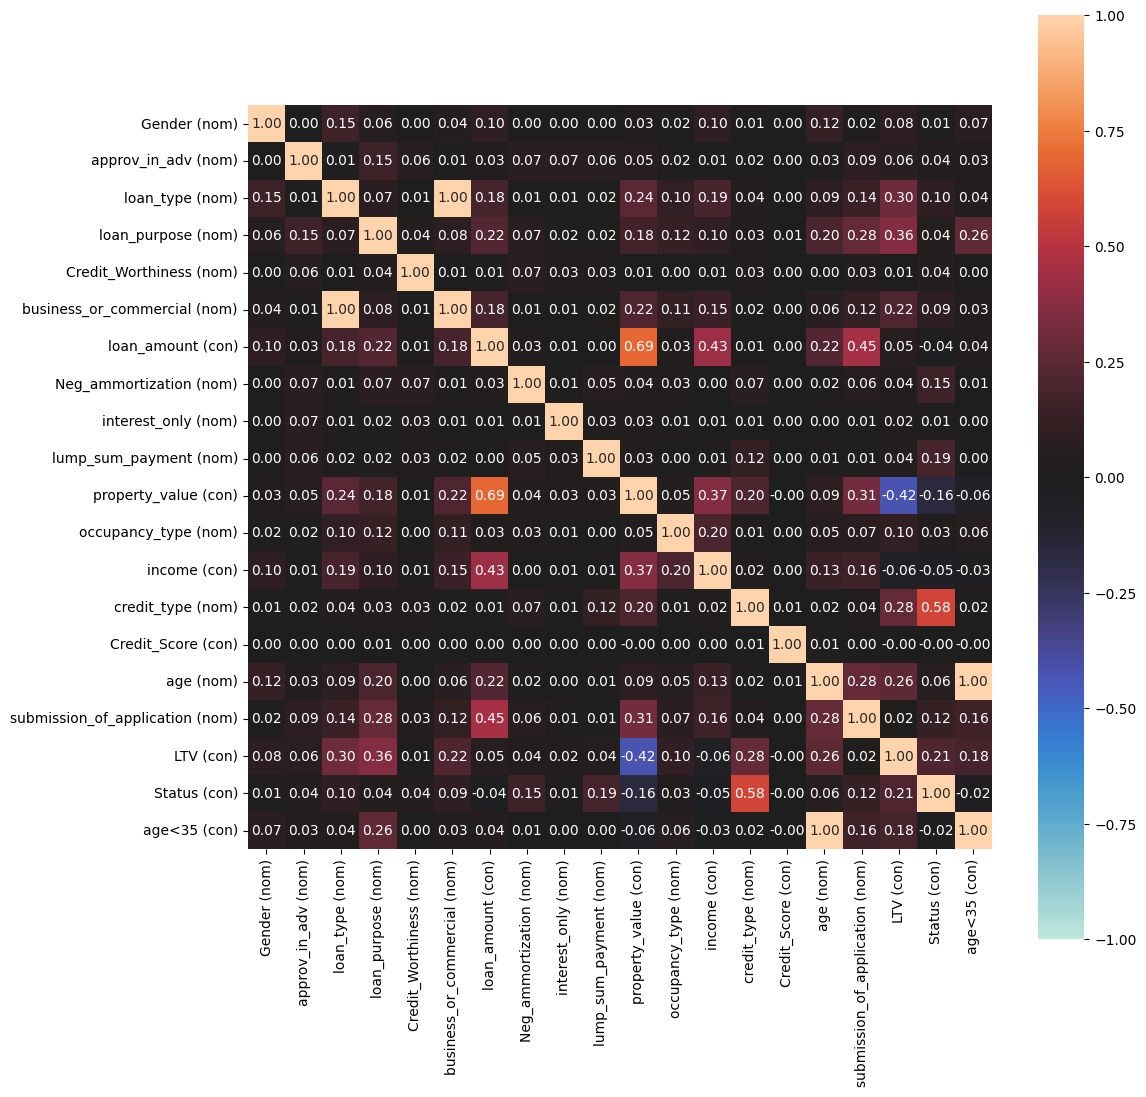

In [44]:
dython.nominal.associations(
    df_loans, nominal_columns=cat_cols, mark_columns=True, figsize=(12, 12));


In [36]:
df_loans = df_loans.drop(['age'], axis=1)

In [28]:
# one hot encode categorical columns
df_loans_dummies = pd.get_dummies(df_loans, columns=cat_cols)

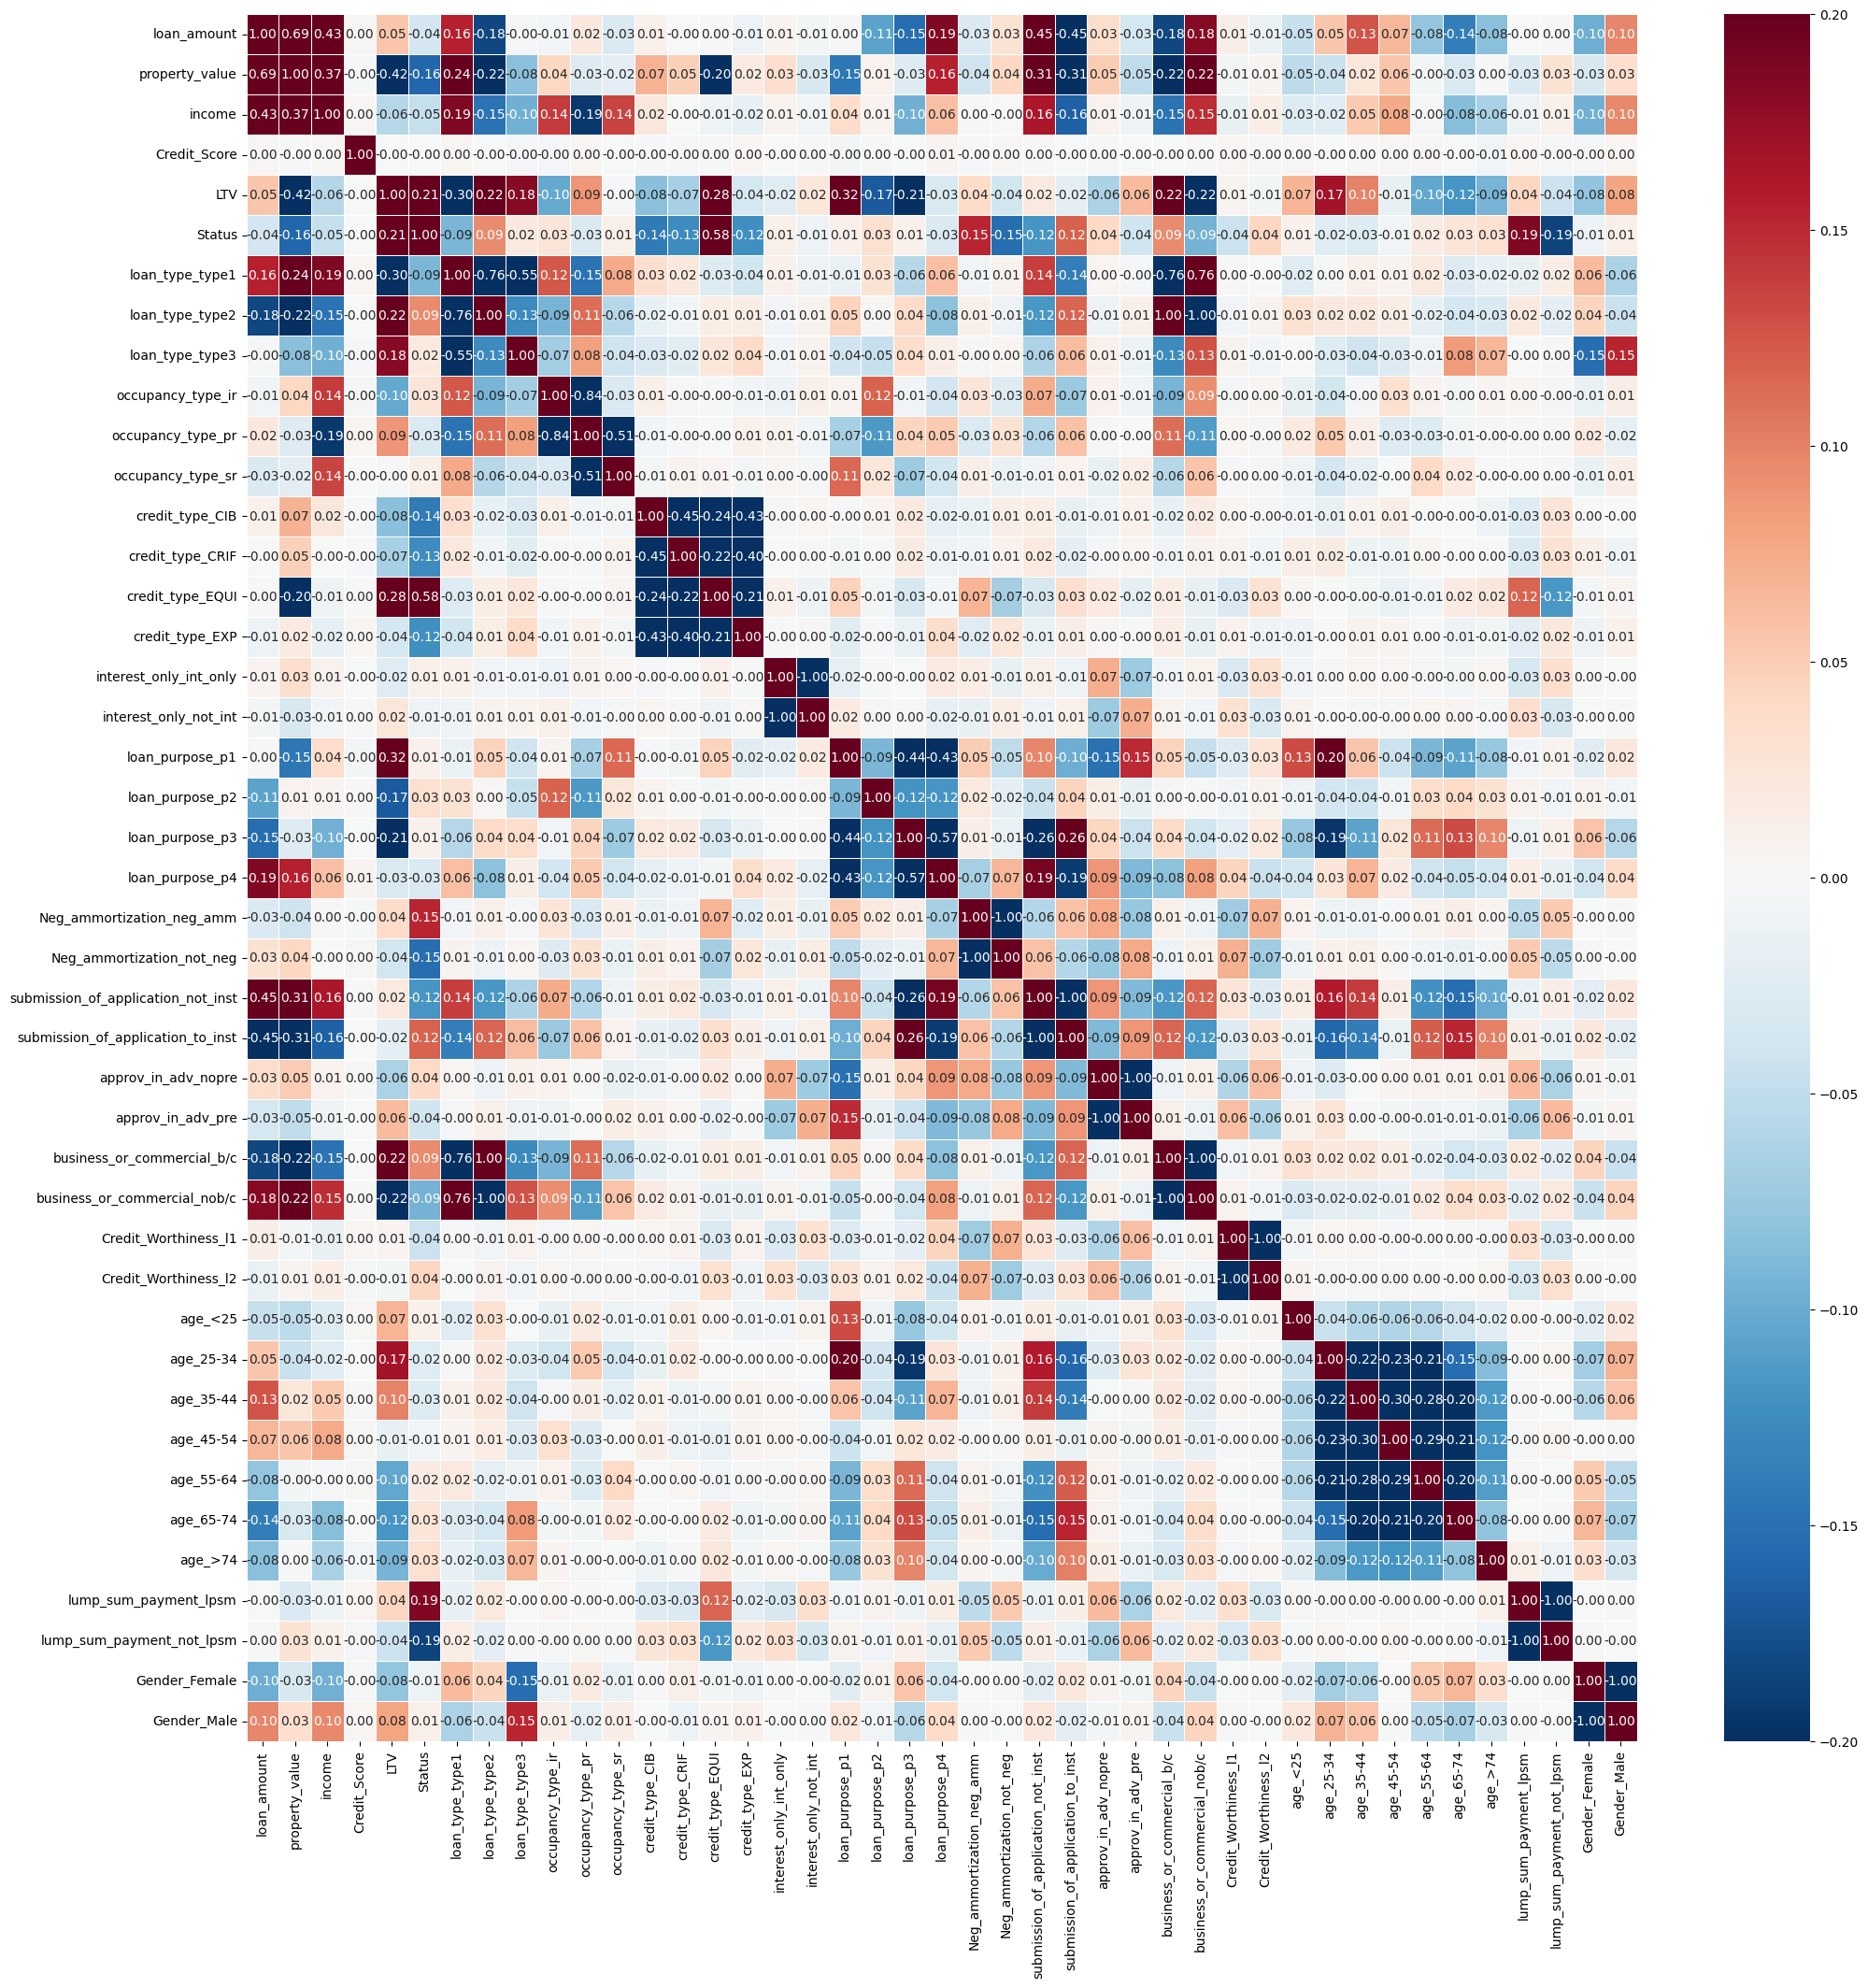

In [29]:
# calculate correlation of dummie variables
corr = df_loans_dummies.corr()

# plot correlation matrix
plt.figure(figsize=(24, 24))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

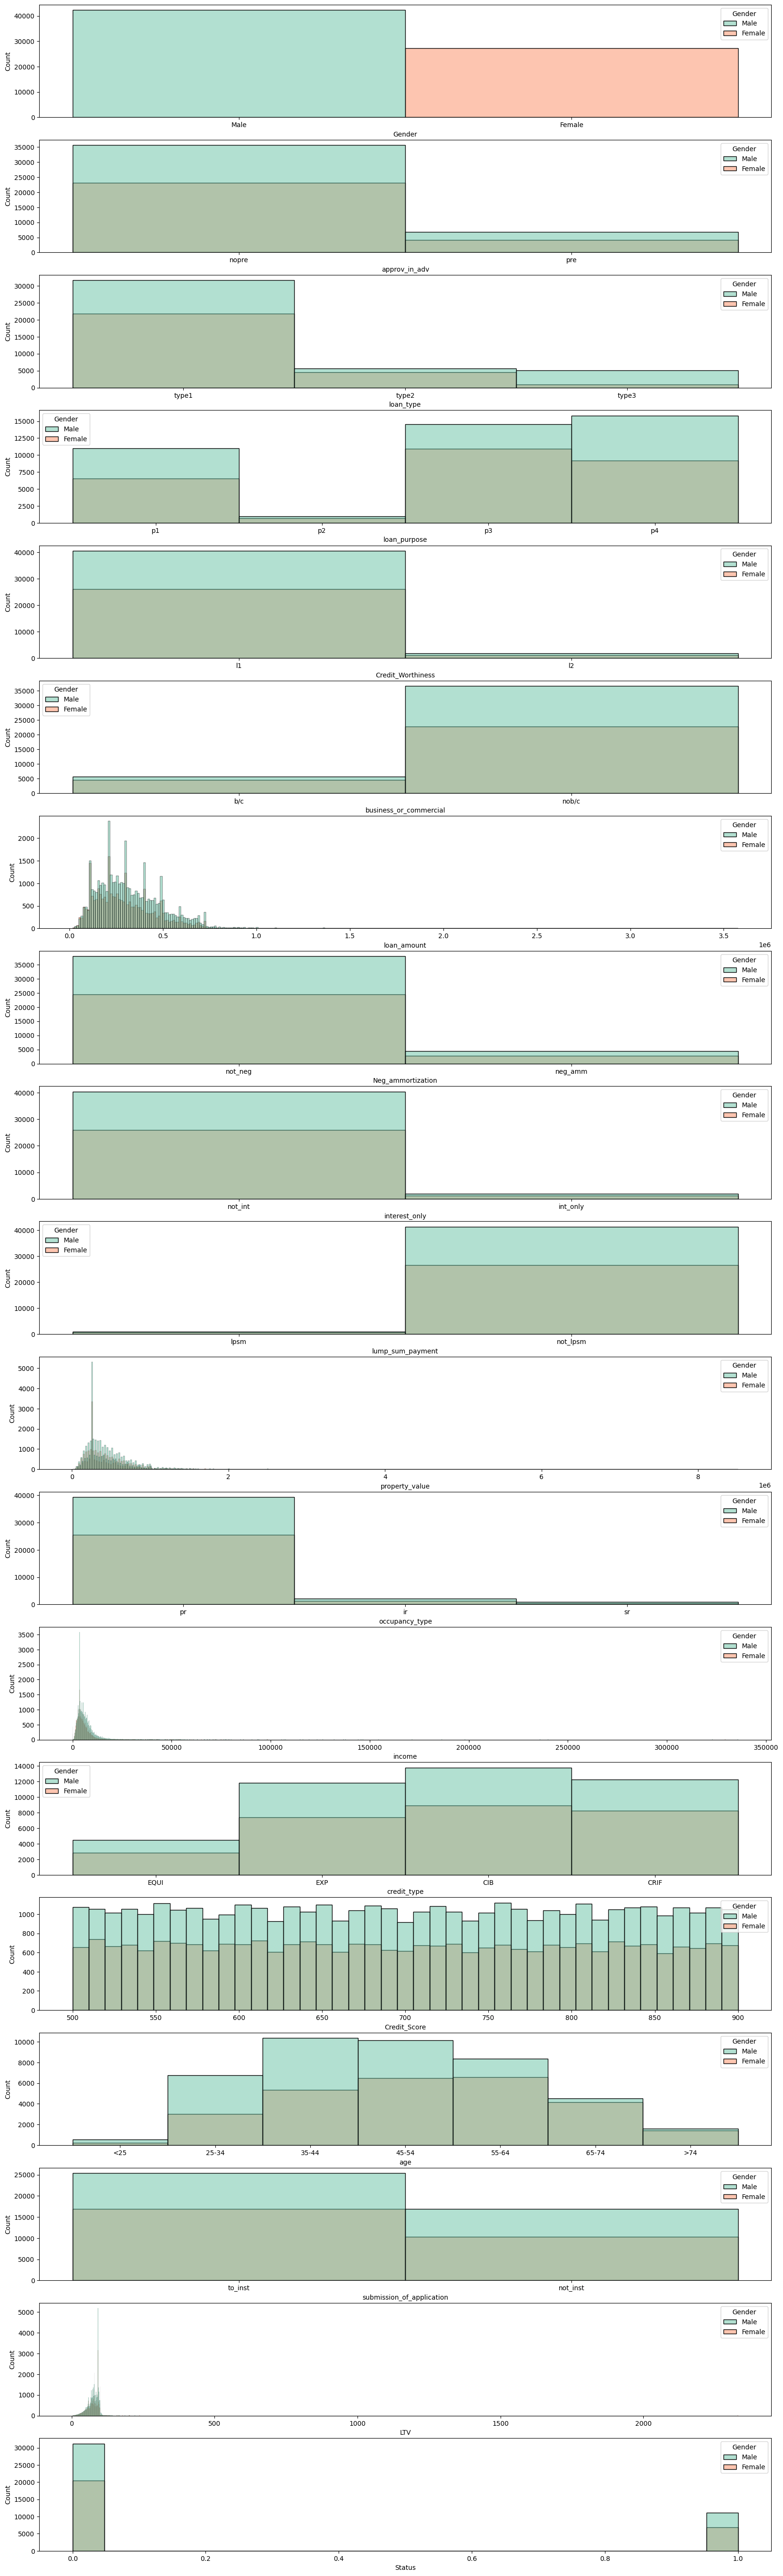

In [27]:
# plot feature distributions for both genders in one plot
df_loans['age'] = pd.Categorical(df_loans['age'], ['<25','25-34','35-44','45-54','55-64','65-74', '>74'])
df_loans['loan_type'] = pd.Categorical(df_loans['loan_type'], ['type1','type2','type3'])
df_loans['loan_purpose'] = pd.Categorical(df_loans['loan_purpose'], ['p1', 'p2', 'p3', 'p4'])
fig, axes = plt.subplots(19, figsize=(20, 70))
for i, feature in enumerate(df_loans.columns):
    sns.histplot(data=df_loans, x=feature, hue='Gender', ax=axes[i], palette='Set2')
plt.show()

In [205]:
cols = list(features.columns)

In [208]:
for i, col in enumerate(cols):
    if "Gender" in col:
        print(col)

Gender_Female
Gender_Male


In [218]:
# one hot encode data
dummies_df_loans = pd.get_dummies(df_loans, columns=cat_cols, drop_first=False)
# remove target variable from features
labels = dummies_df_loans.Status
features = dummies_df_loans.drop("Status", axis=1)

# reorder so cloumns with "Gender" or "age" in them are at the end
cols = list(features.columns)
protected_cols = []
for i, col in enumerate(cols):
    if "Gender" in col:
        protected_cols.append(col)

for i, col in enumerate(cols):
    if "age" in col:
        protected_cols.append(col)

cols = list(set(cols) - set(protected_cols))

cols = cols + protected_cols
features = features[cols]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Gender" in f) or ("age" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 33 (Gender_Female)
Column ID: 34 (Gender_Male)
Column ID: 35 (age_<25)
Column ID: 36 (age_25-34)
Column ID: 37 (age_35-44)
Column ID: 38 (age_45-54)
Column ID: 39 (age_55-64)
Column ID: 40 (age_65-74)
Column ID: 41 (age_>74)
[33, 34, 35, 36, 37, 38, 39, 40, 41]


In [203]:
protected_cols

['Gender_Female', 'age_<25', 'age_35-44', 'age_55-64', 'age_>74']

In [219]:
# last columns of our data contains the protected features
protected = X_train[:, -9:]
nonprotected = X_train[:, :-9]

protected_test = X_test[:, -9:]
nonprotected_test = X_test[:, :-9]

In [220]:
# create decision tree classifier object
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(nonprotected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.7275853481483836
Precision on test set: 0.9575688073394495
Recall on test set: 0.46234772978959027
F1 score on test set: 0.6235997012696043


In [224]:
def calculate_fairness_metrics_nonencoded(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        group_idx = np.where(groups[group] == 1)
        y_true_group = y_true[group_idx]
        y_pred_group = y_pred[group_idx]
        g = group
        metrics[g] = {}
        metrics[g]['statistical_parity'] = np.mean(y_pred_group)
        metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
        metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics

In [225]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics_nonencoded(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Gender_Female : {'statistical_parity': 0.1221142162818955, 'equalized_odds': 0.45869515794074145, 'equalized_outcome': 0.46471435429668745}
Gender_Male : {'statistical_parity': 0.12731152204836416, 'equalized_odds': 0.4529287990407629, 'equalized_outcome': 0.4608695652173913}
age_<25 : {'statistical_parity': 0.12334801762114538, 'equalized_odds': 0.35868971792538673, 'equalized_outcome': 0.37142857142857144}
age_25-34 : {'statistical_parity': 0.1217450118363206, 'equalized_odds': 0.5060625892896641, 'equalized_outcome': 0.512630014858841}
age_35-44 : {'statistical_parity': 0.1180931744312026, 'equalized_odds': 0.48090552254265934, 'equalized_outcome': 0.4865616311399444}
age_45-54 : {'statistical_parity': 0.11699385286535792, 'equalized_odds': 0.4298584140610632, 'equalized_outcome': 0.43808777429467083}
age_55-64 : {'statistical_parity': 0.12655693950177935, 'equalized_odds': 0.4297143561306223, 'equalized_outcome': 0.4368}
age_65-74 : {'statistical_parity': 0.13804971319311662, 'equa

In [226]:
# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        continue

    score = calculate_metrics(y_test[indices], y_pred[indices])['f1_score'] # accuracy
    bootstrapped_scores.append(score)

print(f"Confidence interval for the f1_score [{interval}]:" + "[{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, ((1-interval)/2)*100),
    np.percentile(bootstrapped_scores, (interval + (1-interval)/2)*100)))

Confidence interval for the f1_score [0.95]:[0.610 - 0.635]


## Fair PCA


In [227]:
df_loans.columns

Index(['Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'business_or_commercial', 'loan_amount',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'property_value', 'occupancy_type', 'income', 'credit_type',
       'Credit_Score', 'age', 'submission_of_application', 'LTV', 'Status'],
      dtype='object')

In [228]:
nonprotected

array([[0.00e+00, 0.00e+00, 0.00e+00, ..., 2.18e+05, 0.00e+00, 0.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, ..., 5.88e+05, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.08e+05, 0.00e+00, 0.00e+00],
       ...,
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.08e+05, 0.00e+00, 0.00e+00],
       [1.00e+00, 0.00e+00, 0.00e+00, ..., 4.48e+05, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 3.18e+05, 0.00e+00, 0.00e+00]])

Text(0.5, 0, 'Principal Component')

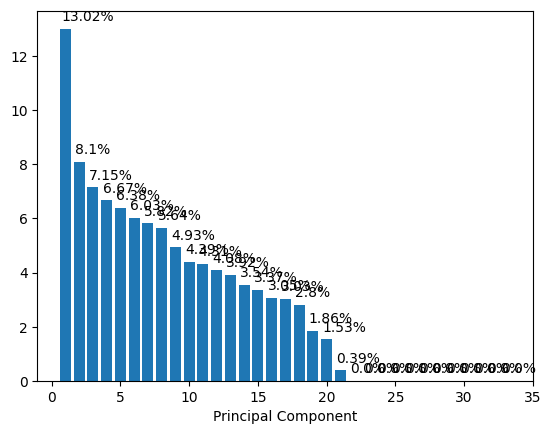

In [229]:
# apply unfair PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(nonprotected)

pca = PCA(n_components=len(features.columns)-9) # - protected features
X_pca = pca.fit_transform(non_protected_features_scaled)

# pca.explained_variance_ratio_
# scree plot bar plot
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
for i in range(len(pca.explained_variance_ratio_)):
    plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
plt.xlabel('Principal Component')

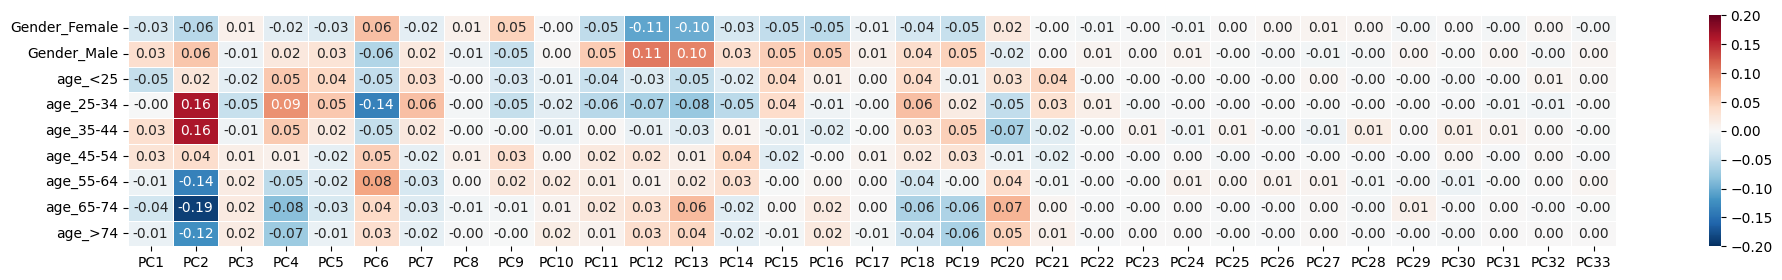

In [240]:
# corr matrix comparing protected
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))

corr = df.corr()
# upt to PC20
group_list = list(groups.columns)
pc_list = ["PC" + str(i) for i in range(1, 34)]
corr.columns = group_list + pc_list

rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(len(group_list))
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = group_list
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

### Keep working from here
need to adapt code for reconstruction error to consider both groups and all age possibilities not only binary gender

In [ ]:
# project test data with pca

# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(nonprotected_test)
X_pca_test = pca.transform(non_protected_features_scaled_test)

# project it back into the original space
X_reconstructed = pca.inverse_transform(X_pca)
X_reconstructed_test = pca.inverse_transform(X_pca_test)

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):

    # 1 is white and 0 is african american
    if protected[i][0] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])
        
    # 1 is male and 0 is female
    if protected[i][1] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))


0.41457962272667187
0.4090418675993557
0.41222689242364413
0.4144574274416098


In [ ]:
# apply fair PCA
import scipy
X = non_protected_features_scaled.copy()
# create Matrix Z with protected features
Z = protected.copy()
# remove mean from each column
Z = Z - np.mean(Z, axis=0)
# find orthonormal null space spanned by ZTX with scipy.linalg.null_space
R = scipy.linalg.null_space(Z.T @ X)

# Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
eigvals, eigvecs = scipy.linalg.eig(R.T @ X.T @ X @ R)
# sort eigenvectors by eigenvalues
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

# get matrix of first 4 eigenvectors
L = eigvecs[:,:2]

# projection matrix U = RL
U = R @ L

# project data
X_projected = X @ U


In [ ]:
X

array([[ 1.55022104, -0.73952767, -0.52241289,  0.84743114],
       [ 1.34540268,  1.35221445, -0.52241289,  0.84743114],
       [-0.49796256,  1.35221445, -0.52241289, -1.18003688],
       ...,
       [-0.2931442 , -0.73952767, -0.52241289,  0.84743114],
       [-0.70278092, -0.73952767, -0.52241289,  0.84743114],
       [ 0.11649252,  1.35221445,  1.91419472, -1.18003688]])

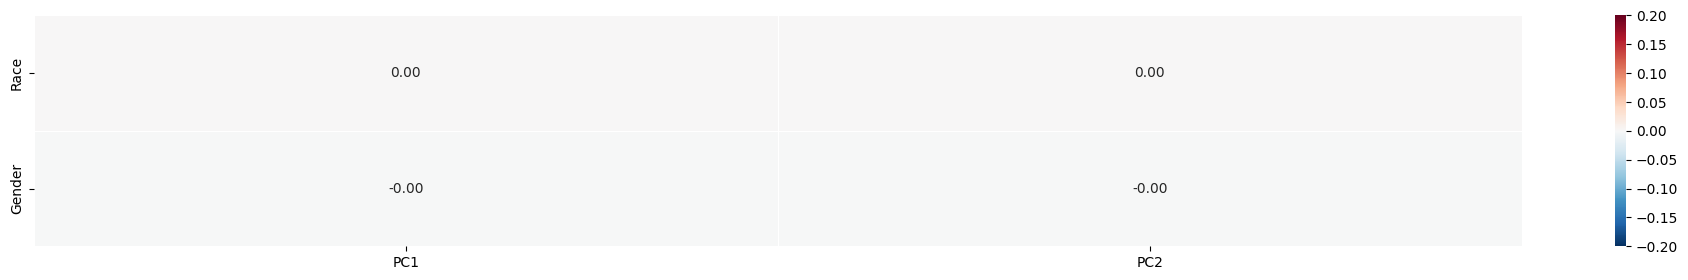

In [ ]:
df = pd.DataFrame(np.concatenate((Z, X_projected), axis=1))

corr = df.corr()
corr.columns=['Race', 'Gender', 'PC1', 'PC2']

rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(2)
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = ["Race", "Gender"]
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

In [ ]:
# project test data
X_test_projected = non_protected_features_scaled_test @ U

# reproject it back into the original space
X_reconstructed = X_projected @ U.T
X_reconstructed_test = X_test_projected @ U.T

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):

    # 1 is white and 0 is african american
    if protected[i][0] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])
        
    # 1 is male and 0 is female
    if protected[i][1] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))

0.43574020287276527
0.42470874673700904
0.4383123336754716
0.43027134025040603


In [ ]:
# run decision tree on fair PCA data
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(X_projected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(X_test_projected)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6203829270330546
Precision on test set: 0.6329588014981273
Recall on test set: 0.46814404432132967
F1 score on test set: 0.5382165605095542


In [ ]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.41875, 'equalized_odds': 0.2680394471838322, 'equalized_outcome': 0.5516528925619835}
Race_Caucasian1 : {'statistical_parity': 0.21153846153846154, 'equalized_odds': 0.14028823964819087, 'equalized_outcome': 0.29831932773109243}
Gender_Male0 : {'statistical_parity': 0.24691358024691357, 'equalized_odds': 0.16551389394490962, 'equalized_outcome': 0.34959349593495936}
Gender_Male1 : {'statistical_parity': 0.3603174603174603, 'equalized_odds': 0.251942849782416, 'equalized_outcome': 0.49248747913188645}
